# 정확도 향상과 Calibration을 하기 위해 Ensemble과 Augmentation 기법 활용

# 데이터 로드 후 train, valid, test 분리

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 데이터 디렉토리 경로
data_dir = "/home/iai/Desktop/son/deeplearningproject/결과"

# 랜덤 시드 고정
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# 데이터 로드
batch_size = 32
img_height = 28
img_width = 28

dataset = image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size
)

# 클래스 비율 확인
class_names = dataset.class_names
print(f"Class names: {class_names}")

class_counts = np.zeros(len(class_names))
for _, labels in dataset:
    class_counts += np.sum(labels.numpy(), axis=0)

print(f"Class distribution: {class_counts}")

2024-05-31 14:57:53.678465: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Found 8135 files belonging to 2 classes.


2024-05-31 14:57:54.417954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-31 14:57:54.447014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 14:57:54.447096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2024-05-31 14:57:54.447106: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-05-31 14:57:54.448561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-31 14:57:54.448582: I tensorflow/stream_executor/pl

Class names: ['언어+뇌신경장애', '청각+뇌신경장애']
Class distribution: [1572. 6563.]


In [2]:
# 데이터셋을 numpy array로 변환
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

images, labels = dataset_to_numpy(dataset)

# 데이터셋을 3:1:1 비율로 나누기
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.4, stratify=labels, random_state=random_seed)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=random_seed)

# numpy array를 tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

# 각 데이터셋의 클래스 비율 확인
def get_class_distribution(labels):
    class_counts = np.sum(labels, axis=0)
    return class_counts

print(f"Train class distribution: {get_class_distribution(train_labels)}")
print(f"Validation class distribution: {get_class_distribution(val_labels)}")
print(f"Test class distribution: {get_class_distribution(test_labels)}")


Train class distribution: [ 943. 3938.]
Validation class distribution: [ 315. 1312.]
Test class distribution: [ 314. 1313.]


# 평가지표

In [3]:
def calculate_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(np.max(y_prob, axis=1), bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == np.argmax(y_prob[bin_mask], axis=1))
            bin_confidence = np.mean(np.max(y_prob[bin_mask], axis=1))
            ece += np.abs(bin_accuracy - bin_confidence) * bin_size / len(y_true)
    return ece

def calculate_oe(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(np.max(y_prob, axis=1), bins) - 1
    oe = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == np.argmax(y_prob[bin_mask], axis=1))
            bin_confidence = np.mean(np.max(y_prob[bin_mask], axis=1))
            if bin_confidence > bin_accuracy:
                oe += (bin_confidence - bin_accuracy) * bin_size / len(y_true)
    return oe

# 모든 실험은 10회 반복해서 진행

# Baseline1

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 체크포인트 경로 확인 및 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 모델 정의 함수
def create_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 결과 저장용 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []
histories = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    model = create_model()
    
    checkpoint_path_baseline1 = os.path.join(checkpoint_dir, f"best_model_baseline1_{i+1}.h5")
    checkpoint_baseline1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_baseline1, monitor='val_loss', save_best_only=True, mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[checkpoint_baseline1, reduce_lr],
        verbose=1
    )

    histories.append(history)

    model.load_weights(checkpoint_path_baseline1)

    loss, accuracy = model.evaluate(test_dataset)
    accuracies.append(accuracy)

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    
    accuracies.append(report['accuracy'])
    recalls.append(report['weighted avg']['recall'])
    precisions.append(report['weighted avg']['precision'])
    f1_scores.append(report['weighted avg']['f1-score'])

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    ece_values.append(ece)
    oe_values.append(oe)


Experiment 1/10
Epoch 1/100


2024-05-31 14:57:55.730768: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-31 14:57:56.035902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-05-31 14:57:56.443839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 27/153 [====>.........................] - ETA: 0s - loss: 0.5088 - accuracy: 0.8102  

2024-05-31 14:57:56.681770: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-05-31 14:57:56.733488: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


153/153 [==============================] - 2s 3ms/step - loss: 0.4410 - accuracy: 0.8271 - val_loss: 0.4595 - val_accuracy: 0.8205
Epoch 2/100
153/153 [==============================] - 0s 2ms/step - loss: 0.3572 - accuracy: 0.8607 - val_loss: 0.3608 - val_accuracy: 0.8623
Epoch 3/100
153/153 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8773 - val_loss: 0.3289 - val_accuracy: 0.8642
Epoch 4/100
153/153 [==============================] - 0s 2ms/step - loss: 0.2471 - accuracy: 0.9017 - val_loss: 0.3218 - val_accuracy: 0.8728
Epoch 5/100
153/153 [==============================] - 0s 2ms/step - loss: 0.2214 - accuracy: 0.9109 - val_loss: 0.4468 - val_accuracy: 0.8752
Epoch 6/100
153/153 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9297 - val_loss: 0.3531 - val_accuracy: 0.8863
Epoch 7/100
153/153 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9389 - val_loss: 0.3556 - val_accuracy: 0.8752
Epoch 8/100

In [5]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9091 ± 0.01
Recall: 0.9091 ± 0.01
Precision: 0.9063 ± 0.01
F1-score: 0.9038 ± 0.01
ECE: 0.0412 ± 0.01
OE: 0.0394 ± 0.01


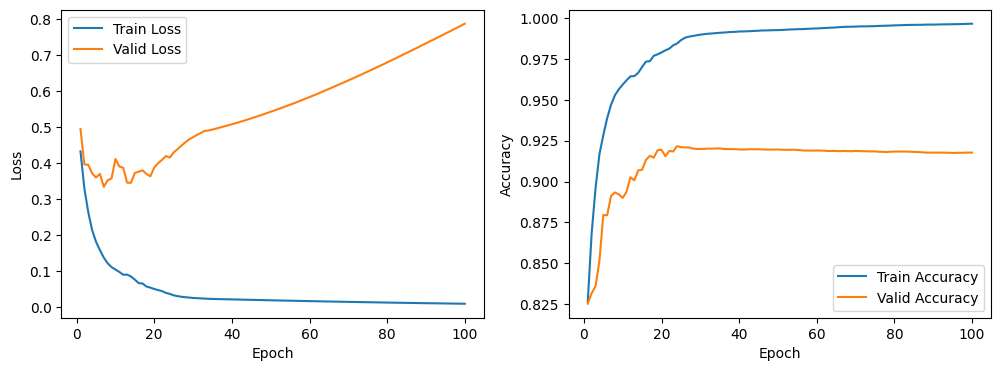

In [6]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Baseline2

In [7]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"
# Pretrained 모델 로드
ae_model = tf.keras.models.load_model('./pretrained_model/ae_model.h5')
mlp_model_template = tf.keras.models.load_model('./pretrained_model/Speech_classification.h5')

# 특징 벡터 추출
train_features = ae_model.predict(train_images)
val_features = ae_model.predict(val_images)
test_features = ae_model.predict(test_images)

# 레이블을 인코딩 (필요한 경우)
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# 특징 벡터를 사용한 데이터셋 생성
train_dataset_new = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size)
val_dataset_new = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(batch_size)
test_dataset_new = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size)

# 반복 실험 결과 저장 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []
histories = []

for i in range(10):
    print(f"Experiment {i+1}/10")

    # MLP 모델 정의 및 드롭아웃 추가
    mlp_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(train_features.shape[1],)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    # 모델 컴파일
    mlp_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    # 체크포인트 설정
    checkpoint_path_baseline2 = os.path.join(checkpoint_dir, f"best_model_baseline2_{i+1}.h5")
    checkpoint_baseline2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_baseline2, monitor='val_loss', save_best_only=True, mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    # 모델 학습
    history = mlp_model.fit(
        train_dataset_new,
        validation_data=val_dataset_new,
        epochs=100,
        callbacks=[checkpoint_baseline2, reduce_lr],
        verbose=1
    )

    histories.append(history)

    mlp_model.load_weights(checkpoint_path_baseline2)

    # 모델 평가
    loss, accuracy = mlp_model.evaluate(test_dataset_new)

    accuracies.append(accuracy)

    # 테스트 데이터에 대한 예측 수행
    y_true = np.concatenate([y for x, y in test_dataset_new], axis=0)
    y_pred = mlp_model.predict(test_dataset_new)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 분류 보고서 생성
    report_mlp = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    
    recalls.append(report_mlp['weighted avg']['recall'])
    precisions.append(report_mlp['weighted avg']['precision'])
    f1_scores.append(report_mlp['weighted avg']['f1-score'])

    ece = calculate_ece(y_true, y_pred)
    oe = calculate_oe(y_true, y_pred)

    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 0s 1ms/step - loss: 0.8297 - accuracy: 0.7726 - val_loss: 0.4961 - val_accuracy: 0.8101
Epoch 2/100
153/153 [==============================] - 0s 1ms/step - loss: 0.4660 - accuracy: 0.8086 - val_loss: 0.4458 - val_accuracy: 0.8199
Epoch 3/100
153/153 [==============================] - 0s 962us/step - loss: 0.4334 - accuracy: 0.8236 - val_loss: 0.4334 - val_accuracy: 0.8175
Epoch 4/100
153/153 [==============================] - 0s 947us/step - loss: 0.4131 - accuracy: 0.8302 - val_loss: 0.4415 - val_accuracy: 0.8002
Epoch 5/100
153/153 [==============================] - 0s 967us/step - loss: 0.3934 - accuracy: 0.8341 - val_loss: 0.4185 - val_accuracy: 0.8162
Epoch 6/100
153/153 [==============================] - 0s 897us/step - loss: 0.3716 - accuracy: 0.8445 - val_loss: 0.3959 - val_accuracy: 0.8316
Epoch 7/100
153/153 [==============================] - 0s 875us/step - loss: 0.3476 - accuracy: 0.8556 - val_loss: 0.4

In [8]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.8524 ± 0.01
Recall: 0.8524 ± 0.01
Precision: 0.8422 ± 0.01
F1-score: 0.8438 ± 0.01
ECE: 0.0325 ± 0.01
OE: 0.0192 ± 0.01


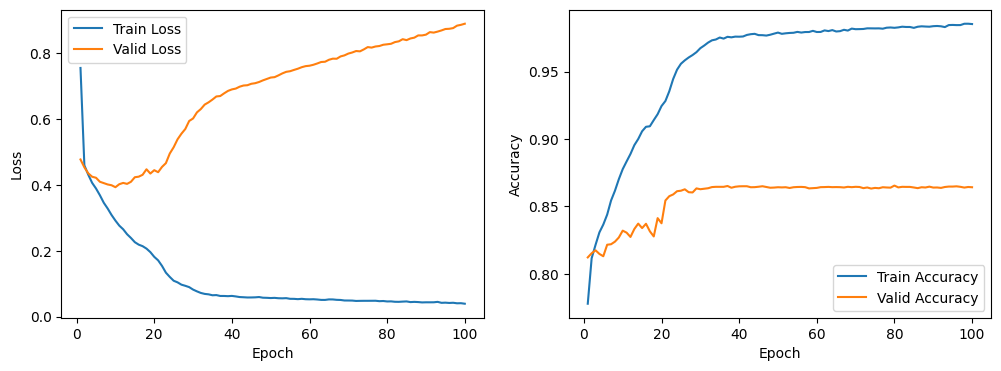

In [9]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Trial 1 : ensemble (output 평균값 이용)

## 앙상블 코드로 학습 과정이 너무 길게 나오므로 verbose를 0으로 하여 표기 생략하겠습니다.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 모델 정의
def create_baseline1_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# VGG 모델 정의
def create_vgg_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# DenseNet 모델 정의
def create_densenet_model():
    def dense_block(x, blocks, growth_rate):
        for _ in range(blocks):
            x = conv_block(x, growth_rate)
        return x

    def conv_block(x, growth_rate):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.ReLU()(x1)
        x1 = layers.Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.ReLU()(x1)
        x1 = layers.Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
        x = layers.Concatenate()([x, x1])
        return x

    def transition_block(x, reduction):
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
        x = layers.AveragePooling2D((2, 2), strides=2)(x)
        return x

    inputs = layers.Input(shape=(28, 28, 3))
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(inputs)
    x = dense_block(x, blocks=4, growth_rate=12)
    x = transition_block(x, reduction=0.5)
    x = dense_block(x, blocks=4, growth_rate=12)
    x = transition_block(x, reduction=0.5)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ResNet 모델 정의
def create_resnet_model():
    def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
        shortcut = x
        if conv_shortcut:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([shortcut, x])
        x = layers.ReLU()(x)
        return x

    inputs = layers.Input(shape=(28, 28, 3))
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# SqueezeNet 모델 정의
def create_squeezenet_model(input_shape=(28, 28, 3), num_classes=2):
    def fire_module(x, squeeze_filters, expand_filters):
        squeeze = layers.Conv2D(squeeze_filters, (1, 1), activation='relu')(x)
        expand_1x1 = layers.Conv2D(expand_filters, (1, 1), activation='relu')(squeeze)
        expand_3x3 = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(squeeze)
        return layers.Concatenate()([expand_1x1, expand_3x3])
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), padding='valid', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Activation('softmax')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, model_name):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    checkpoint_path_ensemble = os.path.join(checkpoint_dir, f"best_model_trial1_{model_name}.h5")
    checkpoint_ensemble = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_ensemble, monitor='val_loss', save_best_only=True, mode='min')

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        batch_size=20,
        callbacks=[checkpoint_ensemble, reduce_lr],
        verbose=0
    )

    model.load_weights(checkpoint_path_ensemble)

    loss, accuracy = model.evaluate(test_dataset)
    print(f"Valid loss: {loss}")
    print(f"Valid accuracy: {accuracy}")

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    return history, report, y_pred, y_true_classes

# 실험 결과 저장 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []
histories = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    # 모델 1 (Baseline1)
    model1 = create_baseline1_model()
    history1, report1, y_pred1, y_true_classes = train_and_evaluate_model(model1, train_dataset, val_dataset, test_dataset, "baseline1")

    # 모델 2 (VGG)
    model2 = create_vgg_model()
    history2, report2, y_pred2, _ = train_and_evaluate_model(model2, train_dataset, val_dataset, test_dataset, "vgg")

    # 모델 3 (DenseNet)
    model3 = create_densenet_model()
    history3, report3, y_pred3, _ = train_and_evaluate_model(model3, train_dataset, val_dataset, test_dataset, "densenet")

    # 모델 4 (ResNet)
    model4 = create_resnet_model()
    history4, report4, y_pred4, _ = train_and_evaluate_model(model4, train_dataset, val_dataset, test_dataset, "ResNet")

    # 모델 5 (SqueezeNet)
    model5 = create_squeezenet_model()
    history5, report5, y_pred5, _ = train_and_evaluate_model(model5, train_dataset, val_dataset, test_dataset, "squeezenet")

    # 앙상블 예측
    y_pred_ensemble = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5) / 5
    y_pred_classes_ensemble = np.argmax(y_pred_ensemble, axis=1)

    # 앙상블 분류 보고서 생성
    report_ensemble = classification_report(y_true_classes, y_pred_classes_ensemble, target_names=class_names, output_dict=True)
    accuracy_ensemble = report_ensemble['accuracy']
    recall_ensemble = report_ensemble['weighted avg']['recall']
    precision_ensemble = report_ensemble['weighted avg']['precision']
    f1_score_ensemble = report_ensemble['weighted avg']['f1-score']

    print(f"Ensemble Accuracy: {accuracy_ensemble}")
    print(f"Ensemble Recall: {recall_ensemble}")
    print(f"Ensemble Precision: {precision_ensemble}")
    print(f"Ensemble F1-score: {f1_score_ensemble}")

    # ECE와 OE 계산
    ece_ensemble = calculate_ece(y_true_classes, y_pred_ensemble)
    oe_ensemble = calculate_oe(y_true_classes, y_pred_ensemble)

    print(f"Ensemble ECE: {ece_ensemble}")
    print(f"Ensemble OE: {oe_ensemble}")
    
    accuracies.append(accuracy_ensemble)
    recalls.append(recall_ensemble)
    precisions.append(precision_ensemble)
    f1_scores.append(f1_score_ensemble)
    ece_values.append(ece_ensemble)
    oe_values.append(oe_ensemble)
    histories.append((history1, history2, history3, history4, history5))


trial_dir = "/home/iai/Desktop/son/deeplearningproject/trial_model"
# 최종 학습된 모델 저장
final_model_path = os.path.join(trial_dir, "trial_1.h5")
model.save(final_model_path)
print(f"Final ensemble model saved at {final_model_path}")


Experiment 1/10
51/51 [==============================] - 0s 1ms/step - loss: 0.2290 - accuracy: 0.9299
Valid loss: 0.22898316383361816
Valid accuracy: 0.9299324154853821
51/51 [==============================] - 0s 1ms/step - loss: 0.1915 - accuracy: 0.9250
Valid loss: 0.19153282046318054
Valid accuracy: 0.925015389919281
51/51 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.9195
Valid loss: 0.2776239216327667
Valid accuracy: 0.9194837212562561


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9373
Valid loss: 0.22966596484184265
Valid accuracy: 0.9373079538345337
51/51 [==============================] - 0s 2ms/step - loss: 0.3392 - accuracy: 0.8814
Valid loss: 0.33921095728874207
Valid accuracy: 0.8813767433166504
Ensemble Accuracy: 0.9459127228027043
Ensemble Recall: 0.9459127228027043
Ensemble Precision: 0.9465743500345216
Ensemble F1-score: 0.9433114683720072
Ensemble ECE: 0.030207465306043506
Ensemble OE: 0.0
Experiment 2/10


2024-05-31 15:13:05.951735: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2394 - accuracy: 0.9109
Valid loss: 0.23937824368476868
Valid accuracy: 0.9108788967132568
51/51 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.9121
Valid loss: 0.23355691134929657
Valid accuracy: 0.9121081829071045
51/51 [==============================] - 0s 2ms/step - loss: 0.2778 - accuracy: 0.9336
Valid loss: 0.2778233289718628
Valid accuracy: 0.9336201548576355


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2034 - accuracy: 0.9471
Valid loss: 0.20338848233222961
Valid accuracy: 0.9471420049667358
51/51 [==============================] - 0s 3ms/step - loss: 0.3021 - accuracy: 0.8623
Valid loss: 0.30208098888397217
Valid accuracy: 0.8623232841491699
Ensemble Accuracy: 0.9440688383527965
Ensemble Recall: 0.9440688383527965
Ensemble Precision: 0.9463647244412552
Ensemble F1-score: 0.940666686569994
Ensemble ECE: 0.033490714187188346
Ensemble OE: 0.0
Experiment 3/10


2024-05-31 15:19:34.941782: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.9103
Valid loss: 0.2502221465110779
Valid accuracy: 0.9102643132209778
51/51 [==============================] - 0s 1ms/step - loss: 0.2412 - accuracy: 0.9090
Valid loss: 0.24124543368816376
Valid accuracy: 0.9090350270271301
51/51 [==============================] - 0s 2ms/step - loss: 0.2037 - accuracy: 0.9361
Valid loss: 0.20372885465621948
Valid accuracy: 0.936078667640686


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9392
Valid loss: 0.19460885226726532
Valid accuracy: 0.9391518235206604
51/51 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.8943
Valid loss: 0.3253317177295685
Valid accuracy: 0.8942839503288269
Ensemble Accuracy: 0.9422249539028887
Ensemble Recall: 0.9422249539028887
Ensemble Precision: 0.9435638365764794
Ensemble F1-score: 0.9389614718410048
Ensemble ECE: 0.02060400377260661
Ensemble OE: 0.0
Experiment 4/10


2024-05-31 15:26:05.874146: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2546 - accuracy: 0.9256
Valid loss: 0.2546287178993225
Valid accuracy: 0.9256299734115601
51/51 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.9348
Valid loss: 0.19212405383586884
Valid accuracy: 0.9348494410514832
51/51 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9361
Valid loss: 0.2188504934310913
Valid accuracy: 0.936078667640686


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.9281
Valid loss: 0.2995915412902832
Valid accuracy: 0.9280884861946106
51/51 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8113
Valid loss: 0.39852768182754517
Valid accuracy: 0.8113091588020325
Ensemble Accuracy: 0.9502151198524893
Ensemble Recall: 0.9502151198524893
Ensemble Precision: 0.9525055131919299
Ensemble F1-score: 0.9474456106159405
Ensemble ECE: 0.04133052787827656
Ensemble OE: 0.0
Experiment 5/10


2024-05-31 15:32:35.754648: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2397 - accuracy: 0.9133
Valid loss: 0.23974290490150452
Valid accuracy: 0.9133374094963074
51/51 [==============================] - 0s 1ms/step - loss: 0.2108 - accuracy: 0.9140
Valid loss: 0.2107841968536377
Valid accuracy: 0.9139520525932312
51/51 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9201
Valid loss: 0.21698097884655
Valid accuracy: 0.9200983643531799


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.9312
Valid loss: 0.20517215132713318
Valid accuracy: 0.931161642074585
51/51 [==============================] - 0s 3ms/step - loss: 0.3315 - accuracy: 0.8746
Valid loss: 0.33146393299102783
Valid accuracy: 0.8746158480644226
Ensemble Accuracy: 0.9422249539028887
Ensemble Recall: 0.9422249539028887
Ensemble Precision: 0.9453583699543275
Ensemble F1-score: 0.938349713507286
Ensemble ECE: 0.039841619091819366
Ensemble OE: 0.0
Experiment 6/10


2024-05-31 15:39:07.308595: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2632 - accuracy: 0.9201
Valid loss: 0.26321956515312195
Valid accuracy: 0.9200983643531799
51/51 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.9213
Valid loss: 0.2173578441143036
Valid accuracy: 0.9213275909423828
51/51 [==============================] - 0s 2ms/step - loss: 0.2506 - accuracy: 0.9318
Valid loss: 0.2506120502948761
Valid accuracy: 0.9317762851715088


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9392
Valid loss: 0.1925879269838333
Valid accuracy: 0.9391518235206604
51/51 [==============================] - 0s 2ms/step - loss: 0.3825 - accuracy: 0.8549
Valid loss: 0.38246017694473267
Valid accuracy: 0.8549477458000183
Ensemble Accuracy: 0.942839582052858
Ensemble Recall: 0.942839582052858
Ensemble Precision: 0.9455704224997998
Ensemble F1-score: 0.9391600091274813
Ensemble ECE: 0.031753274730619084
Ensemble OE: 0.0004432592644014465
Experiment 7/10


2024-05-31 15:45:37.716129: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.3422 - accuracy: 0.9078
Valid loss: 0.3422396183013916
Valid accuracy: 0.9078058004379272
51/51 [==============================] - 0s 1ms/step - loss: 0.2244 - accuracy: 0.9164
Valid loss: 0.22435115277767181
Valid accuracy: 0.9164105653762817
51/51 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9293
Valid loss: 0.23325064778327942
Valid accuracy: 0.9293177723884583


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2170 - accuracy: 0.9262
Valid loss: 0.2169724404811859
Valid accuracy: 0.9262446165084839
51/51 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8482
Valid loss: 0.3476104438304901
Valid accuracy: 0.8481868505477905
Ensemble Accuracy: 0.9434542102028273
Ensemble Recall: 0.9434542102028273
Ensemble Precision: 0.9458085242885431
Ensemble F1-score: 0.9399648980220232
Ensemble ECE: 0.04935503518867144
Ensemble OE: 0.0
Experiment 8/10


2024-05-31 15:52:06.576265: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.3004 - accuracy: 0.9103
Valid loss: 0.3003968894481659
Valid accuracy: 0.9102643132209778
51/51 [==============================] - 0s 1ms/step - loss: 0.2058 - accuracy: 0.9183
Valid loss: 0.2058137208223343
Valid accuracy: 0.9182544350624084
51/51 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9164
Valid loss: 0.23140369355678558
Valid accuracy: 0.9164105653762817


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.1999 - accuracy: 0.9330
Valid loss: 0.19989801943302155
Valid accuracy: 0.9330055117607117
51/51 [==============================] - 0s 3ms/step - loss: 0.2962 - accuracy: 0.8795
Valid loss: 0.2962113320827484
Valid accuracy: 0.8795328736305237
Ensemble Accuracy: 0.9391518131530424
Ensemble Recall: 0.9391518131530424
Ensemble Precision: 0.9385191433784283
Ensemble F1-score: 0.9365693590208768
Ensemble ECE: 0.03504378171368622
Ensemble OE: 0.0011929128165617284
Experiment 9/10


2024-05-31 15:58:35.910955: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2605 - accuracy: 0.9090
Valid loss: 0.26053014397621155
Valid accuracy: 0.9090350270271301
51/51 [==============================] - 0s 1ms/step - loss: 0.2179 - accuracy: 0.9109
Valid loss: 0.2178821563720703
Valid accuracy: 0.9108788967132568
51/51 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.9392
Valid loss: 0.22983568906784058
Valid accuracy: 0.9391518235206604


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2096 - accuracy: 0.9250
Valid loss: 0.20956353843212128
Valid accuracy: 0.925015389919281
51/51 [==============================] - 0s 3ms/step - loss: 0.4178 - accuracy: 0.8334
Valid loss: 0.41783827543258667
Valid accuracy: 0.8334357738494873
Ensemble Accuracy: 0.9459127228027043
Ensemble Recall: 0.9459127228027043
Ensemble Precision: 0.9477576295234144
Ensemble F1-score: 0.9428575481064725
Ensemble ECE: 0.05953328581624185
Ensemble OE: 0.0
Experiment 10/10


2024-05-31 16:05:05.493813: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.3125 - accuracy: 0.9164
Valid loss: 0.3124532699584961
Valid accuracy: 0.9164105653762817
51/51 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9299
Valid loss: 0.23946087062358856
Valid accuracy: 0.9299324154853821
51/51 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.9318
Valid loss: 0.21671611070632935
Valid accuracy: 0.9317762851715088


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2347 - accuracy: 0.9324
Valid loss: 0.2346595674753189
Valid accuracy: 0.9323909282684326
51/51 [==============================] - 0s 2ms/step - loss: 0.3385 - accuracy: 0.8617
Valid loss: 0.33852124214172363
Valid accuracy: 0.8617086410522461
Ensemble Accuracy: 0.942839582052858
Ensemble Recall: 0.942839582052858
Ensemble Precision: 0.9436647370795448
Ensemble F1-score: 0.9398533938637912
Ensemble ECE: 0.02788403115539225
Ensemble OE: 0.0015727039781463755
Final ensemble model saved at /home/iai/Desktop/son/deeplearningproject/trial_model/trial_1.h5


2024-05-31 16:11:35.239282: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [11]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9439 ± 0.00
Recall: 0.9439 ± 0.00
Precision: 0.9456 ± 0.00
F1-score: 0.9407 ± 0.00
ECE: 0.0369 ± 0.01
OE: 0.0003 ± 0.00


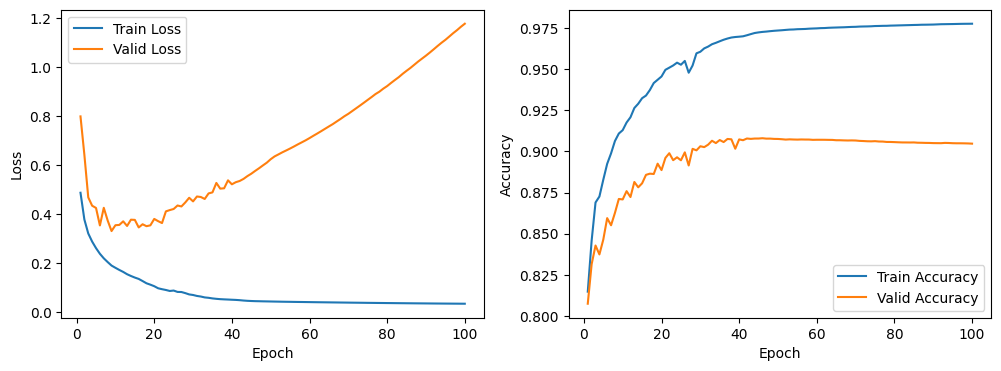

In [12]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([np.mean([history.history['loss'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_val_loss = np.mean([np.mean([history.history['val_loss'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_train_accuracy = np.mean([np.mean([history.history['accuracy'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_val_accuracy = np.mean([np.mean([history.history['val_accuracy'] for history in histories[i]], axis=0) for i in range(10)], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Trial2: ensemble (validation 성능을 기준으로 가중치)

In [13]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 결과 저장 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []
histories = []

def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, model_name):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    checkpoint_path_ensemble = os.path.join(checkpoint_dir, f"best_model_trial2_{model_name}.h5")
    checkpoint_ensemble = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_ensemble, monitor='val_loss', save_best_only=True, mode='min')

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        batch_size=20,
        callbacks=[checkpoint_ensemble, reduce_lr],
        verbose=0
    )

    model.load_weights(checkpoint_path_ensemble)

    loss, accuracy = model.evaluate(test_dataset)
    print(f"Valid loss: {loss}")
    print(f"Valid accuracy: {accuracy}")

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    return history, report, y_pred, y_true_classes

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    # 모델 1 (Baseline1)
    model1 = create_baseline1_model()
    history1, report1, y_pred1, y_true_classes = train_and_evaluate_model(model1, train_dataset, val_dataset, test_dataset, "baseline1")

    # 모델 2 (VGG)
    model2 = create_vgg_model()
    history2, report2, y_pred2, _ = train_and_evaluate_model(model2, train_dataset, val_dataset, test_dataset, "vgg")

    # 모델 3 (DenseNet)
    model3 = create_densenet_model()
    history3, report3, y_pred3, _ = train_and_evaluate_model(model3, train_dataset, val_dataset, test_dataset, "densenet")

    # 모델 4 (ResNet)
    model4 = create_resnet_model()
    history4, report4, y_pred4, _ = train_and_evaluate_model(model4, train_dataset, val_dataset, test_dataset, "ResNet")

   # 모델 5 (SqueezeNet)
    model5 = create_squeezenet_model()
    history5, report5, y_pred5, _ = train_and_evaluate_model(model5, train_dataset, val_dataset, test_dataset, "squeezenet")

    # 모델의 검증 정확도
    accuracy1 = history1.history['val_accuracy'][-1]  # Baseline1 모델의 검증 정확도
    accuracy2 = history2.history['val_accuracy'][-1]  # VGG 모델의 검증 정확도
    accuracy3 = history3.history['val_accuracy'][-1]  # DenseNet 모델의 검증 정확도
    accuracy4 = history4.history['val_accuracy'][-1]  # resnet 모델의 검증 정확도
    accuracy5 = history5.history['val_accuracy'][-1]  # SqueezeNet 모델의 검증 정확도

    # 가중치 계산
    total_accuracy = accuracy1 + accuracy2 + accuracy3 + accuracy4 + accuracy5
    weights = [accuracy1 / total_accuracy, accuracy2 / total_accuracy, accuracy3 / total_accuracy, accuracy4 / total_accuracy, accuracy5 / total_accuracy]

    print(f"Calculated weights: {weights}")

    # 가중 평균 계산
    y_pred_ensemble_weighted = (weights[0] * y_pred1 + weights[1] * y_pred2 + weights[2] * y_pred3 + weights[3] * y_pred4 + weights[4] * y_pred5) / sum(weights)
    y_pred_classes_ensemble_weighted = np.argmax(y_pred_ensemble_weighted, axis=1)

    # 앙상블 분류 보고서 생성
    report_ensemble = classification_report(y_true_classes, y_pred_classes_ensemble_weighted, target_names=class_names, output_dict=True)
    accuracy_ensemble = report_ensemble['accuracy']
    recall_ensemble = report_ensemble['weighted avg']['recall']
    precision_ensemble = report_ensemble['weighted avg']['precision']
    f1_score_ensemble = report_ensemble['weighted avg']['f1-score']

    print(f"Ensemble Accuracy: {accuracy_ensemble}")
    print(f"Ensemble Recall: {recall_ensemble}")
    print(f"Ensemble Precision: {precision_ensemble}")
    print(f"Ensemble F1-score: {f1_score_ensemble}")

    # ECE와 OE 계산
    ece_ensemble = calculate_ece(y_true_classes, y_pred_ensemble_weighted)
    oe_ensemble = calculate_oe(y_true_classes, y_pred_ensemble_weighted)

    print(f"Ensemble ECE: {ece_ensemble}")
    print(f"Ensemble OE: {oe_ensemble}")

    accuracies.append(accuracy_ensemble)
    recalls.append(recall_ensemble)
    precisions.append(precision_ensemble)
    f1_scores.append(f1_score_ensemble)
    ece_values.append(ece_ensemble)
    oe_values.append(oe_ensemble)
    histories.append((history1, history2, history3, history4, history5))


trial_dir = "/home/iai/Desktop/son/deeplearningproject/trial_model"
# 최종 학습된 모델 저장
final_model_path = os.path.join(trial_dir, "trial_2.h5")
model.save(final_model_path)
print(f"Final ensemble model saved at {final_model_path}")

Experiment 1/10
51/51 [==============================] - 0s 1ms/step - loss: 0.2782 - accuracy: 0.9195
Valid loss: 0.27824366092681885
Valid accuracy: 0.9194837212562561
51/51 [==============================] - 0s 1ms/step - loss: 0.1900 - accuracy: 0.9287
Valid loss: 0.1900087296962738
Valid accuracy: 0.9287031292915344
51/51 [==============================] - 0s 2ms/step - loss: 0.2437 - accuracy: 0.9305
Valid loss: 0.24369904398918152
Valid accuracy: 0.9305469989776611


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2353 - accuracy: 0.9336
Valid loss: 0.23527856171131134
Valid accuracy: 0.9336201548576355
51/51 [==============================] - 0s 2ms/step - loss: 0.3212 - accuracy: 0.8771
Valid loss: 0.3211749196052551
Valid accuracy: 0.8770743608474731
Calculated weights: [0.2010956740747544, 0.20350079869766075, 0.19895777976200318, 0.20243185154128512, 0.19401389592429655]
Ensemble Accuracy: 0.9422249539028887
Ensemble Recall: 0.9422249539028887
Ensemble Precision: 0.9435638365764794
Ensemble F1-score: 0.9389614718410048
Ensemble ECE: 0.026301241573118014
Ensemble OE: 0.0
Experiment 2/10


2024-05-31 16:18:05.978085: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2195 - accuracy: 0.9164
Valid loss: 0.21949328482151031
Valid accuracy: 0.9164105653762817
51/51 [==============================] - 0s 1ms/step - loss: 0.2125 - accuracy: 0.9072
Valid loss: 0.21246688067913055
Valid accuracy: 0.9071911573410034
51/51 [==============================] - 0s 2ms/step - loss: 0.1816 - accuracy: 0.9435
Valid loss: 0.1815769076347351
Valid accuracy: 0.9434542059898376


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2118 - accuracy: 0.9250
Valid loss: 0.21175095438957214
Valid accuracy: 0.925015389919281
51/51 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8617
Valid loss: 0.3428860604763031
Valid accuracy: 0.8617086410522461
Calculated weights: [0.2005354700796392, 0.2013386894794772, 0.20200803681564836, 0.20348059056949463, 0.19263721305574058]
Ensemble Accuracy: 0.9452980946527351
Ensemble Recall: 0.9452980946527351
Ensemble Precision: 0.9477782780810309
Ensemble F1-score: 0.9419707154365874
Ensemble ECE: 0.04298911555529956
Ensemble OE: 0.0
Experiment 3/10


2024-05-31 16:24:38.497742: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2645 - accuracy: 0.9287
Valid loss: 0.26449134945869446
Valid accuracy: 0.9287031292915344
51/51 [==============================] - 0s 1ms/step - loss: 0.2419 - accuracy: 0.9041
Valid loss: 0.24185216426849365
Valid accuracy: 0.904118001461029
51/51 [==============================] - 0s 2ms/step - loss: 0.2758 - accuracy: 0.9109
Valid loss: 0.27581891417503357
Valid accuracy: 0.9108788967132568


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2345 - accuracy: 0.9398
Valid loss: 0.2344810664653778
Valid accuracy: 0.9397664666175842
51/51 [==============================] - 0s 2ms/step - loss: 0.3575 - accuracy: 0.8470
Valid loss: 0.35750919580459595
Valid accuracy: 0.8469575643539429
Calculated weights: [0.20257926127030093, 0.20204191571513436, 0.19962385420313147, 0.20351961273496588, 0.19223535607646736]
Ensemble Accuracy: 0.9483712354025814
Ensemble Recall: 0.9483712354025814
Ensemble Precision: 0.9495323466104686
Ensemble F1-score: 0.9458031267650507
Ensemble ECE: 0.045838595792129136
Ensemble OE: 0.0
Experiment 4/10


2024-05-31 16:31:09.609024: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2962 - accuracy: 0.9244
Valid loss: 0.2961685359477997
Valid accuracy: 0.9244007468223572
51/51 [==============================] - 0s 1ms/step - loss: 0.2057 - accuracy: 0.9250
Valid loss: 0.20571526885032654
Valid accuracy: 0.925015389919281
51/51 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9238
Valid loss: 0.22826114296913147
Valid accuracy: 0.9237861037254333


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.1950 - accuracy: 0.9299
Valid loss: 0.1950327455997467
Valid accuracy: 0.9299324154853821
51/51 [==============================] - 0s 3ms/step - loss: 0.3134 - accuracy: 0.8857
Valid loss: 0.3134421110153198
Valid accuracy: 0.8856791853904724
Calculated weights: [0.20056383216842102, 0.20405424038068734, 0.20230903627455418, 0.20217478680052192, 0.19089810437581553]
Ensemble Accuracy: 0.9477566072526121
Ensemble Recall: 0.9477566072526121
Ensemble Precision: 0.9487347062939147
Ensemble F1-score: 0.9452010763394454
Ensemble ECE: 0.029617592793120616
Ensemble OE: 0.0
Experiment 5/10


2024-05-31 16:37:40.706247: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2244 - accuracy: 0.9207
Valid loss: 0.22436942160129547
Valid accuracy: 0.920712947845459
51/51 [==============================] - 0s 1ms/step - loss: 0.2383 - accuracy: 0.9133
Valid loss: 0.2383231222629547
Valid accuracy: 0.9133374094963074
51/51 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.9398
Valid loss: 0.20139583945274353
Valid accuracy: 0.9397664666175842


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.9361
Valid loss: 0.28218910098075867
Valid accuracy: 0.936078667640686
51/51 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8912
Valid loss: 0.2887040078639984
Valid accuracy: 0.8912107944488525
Calculated weights: [0.20147453291521183, 0.20241286755231494, 0.2009383398369293, 0.20080428831746727, 0.19436997137807666]
Ensemble Accuracy: 0.9496004917025199
Ensemble Recall: 0.9496004917025199
Ensemble Precision: 0.9504687551467327
Ensemble F1-score: 0.9472589145514055
Ensemble ECE: 0.02553765951085104
Ensemble OE: 0.0
Experiment 6/10


2024-05-31 16:44:11.135027: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2154 - accuracy: 0.9207
Valid loss: 0.2154339998960495
Valid accuracy: 0.920712947845459
51/51 [==============================] - 0s 1ms/step - loss: 0.2524 - accuracy: 0.9140
Valid loss: 0.2523985207080841
Valid accuracy: 0.9139520525932312
51/51 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.9195
Valid loss: 0.2653142213821411
Valid accuracy: 0.9194837212562561


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2361 - accuracy: 0.9318
Valid loss: 0.23605036735534668
Valid accuracy: 0.9317762851715088
51/51 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8777
Valid loss: 0.3162713646888733
Valid accuracy: 0.877689003944397
Calculated weights: [0.20222908246365917, 0.20182623890249657, 0.19954343701881128, 0.20290049708043573, 0.19350074453459726]
Ensemble Accuracy: 0.942839582052858
Ensemble Recall: 0.942839582052858
Ensemble Precision: 0.9459038945251721
Ensemble F1-score: 0.9390572844410486
Ensemble ECE: 0.03270970309667231
Ensemble OE: 0.0
Experiment 7/10


2024-05-31 16:50:42.995008: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2839 - accuracy: 0.9140
Valid loss: 0.2839428782463074
Valid accuracy: 0.9139520525932312
51/51 [==============================] - 0s 1ms/step - loss: 0.2307 - accuracy: 0.9109
Valid loss: 0.23068170249462128
Valid accuracy: 0.9108788967132568
51/51 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9275
Valid loss: 0.19732552766799927
Valid accuracy: 0.9274739027023315


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2526 - accuracy: 0.9244
Valid loss: 0.25260743498802185
Valid accuracy: 0.9244007468223572
51/51 [==============================] - 0s 3ms/step - loss: 0.3375 - accuracy: 0.8648
Valid loss: 0.3374806046485901
Valid accuracy: 0.8647817969322205
Calculated weights: [0.20189992177891752, 0.20189992177891752, 0.2006957439933027, 0.20377307568968295, 0.1917313367591793]
Ensemble Accuracy: 0.942839582052858
Ensemble Recall: 0.942839582052858
Ensemble Precision: 0.9446646587701085
Ensemble F1-score: 0.9394626012805385
Ensemble ECE: 0.04367724758903158
Ensemble OE: 0.0021023561270162227
Experiment 8/10


2024-05-31 16:57:13.834201: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2385 - accuracy: 0.9262
Valid loss: 0.23846875131130219
Valid accuracy: 0.9262446165084839
51/51 [==============================] - 0s 1ms/step - loss: 0.1980 - accuracy: 0.9256
Valid loss: 0.1979738175868988
Valid accuracy: 0.9256299734115601
51/51 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9336
Valid loss: 0.21331886947155
Valid accuracy: 0.9336201548576355


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2230 - accuracy: 0.9379
Valid loss: 0.22301019728183746
Valid accuracy: 0.9379225373268127
51/51 [==============================] - 0s 2ms/step - loss: 0.3312 - accuracy: 0.8801
Valid loss: 0.3311832547187805
Valid accuracy: 0.8801475167274475
Calculated weights: [0.20536200962976034, 0.205634185959373, 0.20332062776798002, 0.20713118876651226, 0.17855198787637439]
Ensemble Accuracy: 0.9514443761524278
Ensemble Recall: 0.9514443761524278
Ensemble Precision: 0.9536158867617985
Ensemble F1-score: 0.9488258593343167
Ensemble ECE: 0.035828705975521374
Ensemble OE: 0.0
Experiment 9/10


2024-05-31 17:03:44.712730: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 992us/step - loss: 0.3172 - accuracy: 0.9189
Valid loss: 0.31717562675476074
Valid accuracy: 0.9188690781593323
51/51 [==============================] - 0s 1ms/step - loss: 0.1987 - accuracy: 0.9226
Valid loss: 0.19866503775119781
Valid accuracy: 0.9225568771362305
51/51 [==============================] - 0s 2ms/step - loss: 0.2234 - accuracy: 0.9324
Valid loss: 0.2234349101781845
Valid accuracy: 0.9323909282684326


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2417 - accuracy: 0.9293
Valid loss: 0.24171923100948334
Valid accuracy: 0.9293177723884583
51/51 [==============================] - 0s 3ms/step - loss: 0.3240 - accuracy: 0.8746
Valid loss: 0.3240394592285156
Valid accuracy: 0.8746158480644226
Calculated weights: [0.1995989336964862, 0.2016042781788621, 0.2016042781788621, 0.20173797126830234, 0.19545453867748727]
Ensemble Accuracy: 0.9471419791026429
Ensemble Recall: 0.9471419791026429
Ensemble Precision: 0.9477419349087668
Ensemble F1-score: 0.9446861786758644
Ensemble ECE: 0.03101940604170629
Ensemble OE: 0.00036202864772935043
Experiment 10/10


2024-05-31 17:10:15.486848: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


51/51 [==============================] - 0s 1ms/step - loss: 0.2482 - accuracy: 0.9256
Valid loss: 0.24816326797008514
Valid accuracy: 0.9256299734115601
51/51 [==============================] - 0s 1ms/step - loss: 0.2311 - accuracy: 0.9275
Valid loss: 0.2310859113931656
Valid accuracy: 0.9274739027023315
51/51 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9275
Valid loss: 0.19646897912025452
Valid accuracy: 0.9274739027023315


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


51/51 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.9361
Valid loss: 0.22283560037612915
Valid accuracy: 0.936078667640686
51/51 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8715
Valid loss: 0.3076777160167694
Valid accuracy: 0.8715426921844482
Calculated weights: [0.20205937236585977, 0.20286173247769868, 0.1984487842832709, 0.20112329637560977, 0.19550681449756088]
Ensemble Accuracy: 0.9452980946527351
Ensemble Recall: 0.9452980946527351
Ensemble Precision: 0.9464308526439527
Ensemble F1-score: 0.9424403446653485
Ensemble ECE: 0.026630966298479077
Ensemble OE: 0.0016761709006930241
Final ensemble model saved at /home/iai/Desktop/son/deeplearningproject/trial_model/trial_2.h5


2024-05-31 17:16:47.336748: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23396679680 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [14]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9463 ± 0.00
Recall: 0.9463 ± 0.00
Precision: 0.9478 ± 0.00
F1-score: 0.9434 ± 0.00
ECE: 0.0340 ± 0.01
OE: 0.0004 ± 0.00


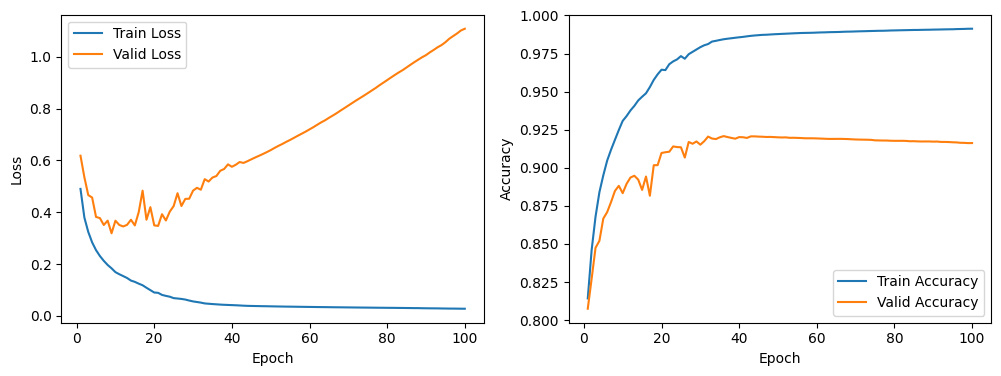

In [15]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([np.mean([history.history['loss'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_val_loss = np.mean([np.mean([history.history['val_loss'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_train_accuracy = np.mean([np.mean([history.history['accuracy'] for history in histories[i]], axis=0) for i in range(10)], axis=0)
avg_val_accuracy = np.mean([np.mean([history.history['val_accuracy'] for history in histories[i]], axis=0) for i in range(10)], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Trial3: ensemble(커널크기 변경) : 음성이미지데이터의 특성인 x축 시간, y축 주파수의 특성을 더 살리기 위해서

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 모델 정의
def create_baseline1_model(kernel_size=(3, 3)):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, model_name):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    checkpoint_path_ensemble = os.path.join(checkpoint_dir, f"best_model_trial3_{model_name}.h5")
    checkpoint_ensemble = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_ensemble, monitor='val_loss', save_best_only=True, mode='min')

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        batch_size=20,
        callbacks=[checkpoint_ensemble, reduce_lr],
        verbose=0
    )

    model.load_weights(checkpoint_path_ensemble)

    loss, accuracy = model.evaluate(test_dataset)
    print(f"Valid loss: {loss}")
    print(f"Valid accuracy: {accuracy}")

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    return history, report, y_pred, y_true_classes

# 커널 크기가 다른 여러 모델 생성
kernel_sizes = [(3, 3), (3, 7), (7, 3), (7, 7)]
histories_all = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for experiment in range(10):
    print(f"Experiment {experiment + 1}/10")
    model_list = []
    histories = []
    reports = []
    y_preds = []

    for kernel_size in kernel_sizes:
        model = create_baseline1_model(kernel_size=kernel_size)
        history, report, y_pred, y_true_classes = train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, f"kernel_{kernel_size[0]}x{kernel_size[1]}")
        model_list.append(model)
        histories.append(history)
        reports.append(report)
        y_preds.append(y_pred)

    # 앙상블 예측
    y_pred_ensemble = np.mean(y_preds, axis=0)
    y_pred_classes_ensemble = np.argmax(y_pred_ensemble, axis=1)

    # 앙상블 분류 보고서 생성
    report_ensemble = classification_report(y_true_classes, y_pred_classes_ensemble, target_names=class_names, output_dict=True)
    accuracy_ensemble = report_ensemble['accuracy']
    recall_ensemble = report_ensemble['weighted avg']['recall']
    precision_ensemble = report_ensemble['weighted avg']['precision']
    f1_score_ensemble = report_ensemble['weighted avg']['f1-score']
    
    print(f"Ensemble Accuracy: {accuracy_ensemble}")
    print(f"Ensemble Recall: {recall_ensemble}")
    print(f"Ensemble Precision: {precision_ensemble}")
    print(f"Ensemble F1-score: {f1_score_ensemble}")

    # ECE와 OE 계산
    ece_ensemble = calculate_ece(y_true_classes, y_pred_ensemble)
    oe_ensemble = calculate_oe(y_true_classes, y_pred_ensemble)

    print(f"Ensemble ECE: {ece_ensemble}")
    print(f"Ensemble OE: {oe_ensemble}")

    histories_all.append(histories)
    accuracies.append(accuracy_ensemble)
    recalls.append(recall_ensemble)
    precisions.append(precision_ensemble)
    f1_scores.append(f1_score_ensemble)
    ece_values.append(ece_ensemble)
    oe_values.append(oe_ensemble)


trial_dir = "/home/iai/Desktop/son/deeplearningproject/trial_model"
# 최종 학습된 모델 저장
final_model_path = os.path.join(trial_dir, "trial_3.h5")
model.save(final_model_path)
print(f"Final ensemble model saved at {final_model_path}")

Experiment 1/10
51/51 [==============================] - 0s 1ms/step - loss: 0.2105 - accuracy: 0.9281
Valid loss: 0.2105264663696289
Valid accuracy: 0.9280884861946106
51/51 [==============================] - 0s 1ms/step - loss: 0.2403 - accuracy: 0.9152
Valid loss: 0.24027256667613983
Valid accuracy: 0.9151813387870789
51/51 [==============================] - 0s 989us/step - loss: 0.2631 - accuracy: 0.9244
Valid loss: 0.26309680938720703
Valid accuracy: 0.9244007468223572
51/51 [==============================] - 0s 1ms/step - loss: 0.2065 - accuracy: 0.9213
Valid loss: 0.20647625625133514
Valid accuracy: 0.9213275909423828
Ensemble Accuracy: 0.9416103257529195
Ensemble Recall: 0.9416103257529195
Ensemble Precision: 0.9427412281155914
Ensemble F1-score: 0.9383621359075844
Ensemble ECE: 0.014470308487885723
Ensemble OE: 0.0
Experiment 2/10
51/51 [==============================] - 0s 1ms/step - loss: 0.2521 - accuracy: 0.9201
Valid loss: 0.2521103322505951
Valid accuracy: 0.920098364353

In [17]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9429 ± 0.00
Recall: 0.9429 ± 0.00
Precision: 0.9437 ± 0.00
F1-score: 0.9399 ± 0.00
ECE: 0.0120 ± 0.00
OE: 0.0016 ± 0.00


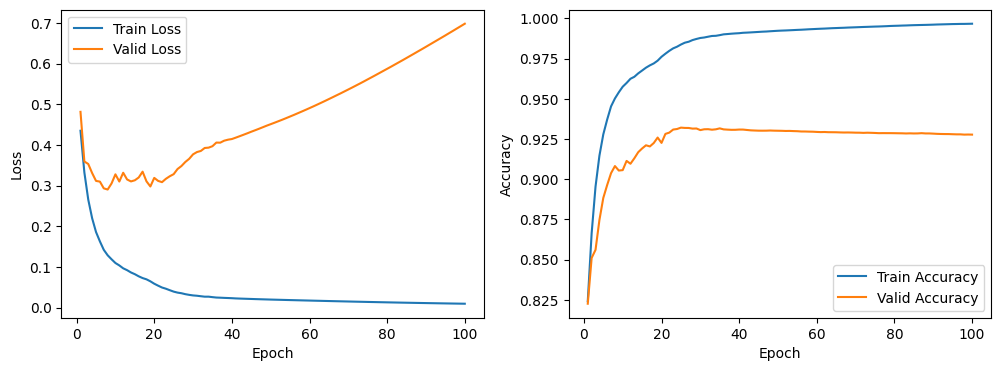

In [18]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([np.mean([history.history['loss'] for history in histories], axis=0) for histories in histories_all], axis=0)
avg_val_loss = np.mean([np.mean([history.history['val_loss'] for history in histories], axis=0) for histories in histories_all], axis=0)
avg_train_accuracy = np.mean([np.mean([history.history['accuracy'] for history in histories], axis=0) for histories in histories_all], axis=0)
avg_val_accuracy = np.mean([np.mean([history.history['val_accuracy'] for history in histories], axis=0) for histories in histories_all], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Trial4: augmentation (음성데이터의 특성을 고려한 augmentation)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 생성기 정의
datagen = ImageDataGenerator(
    # rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

# 증강된 데이터를 이용한 학습 데이터셋 생성
def augment_dataset(images, labels, datagen, batch_size):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        img = img.reshape((1,) + img.shape)
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = aug_iter.next().astype(np.float32)
        augmented_images.append(aug_img.reshape(img.shape[1:]))
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

augmented_train_images, augmented_train_labels = augment_dataset(train_images, train_labels, datagen, batch_size)

# numpy array를 tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
augmented_train_dataset = tf.data.Dataset.from_tensor_slices((augmented_train_images, augmented_train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [20]:
def one_hot_encode_dataset(dataset, num_classes):
    def one_hot_encode(image, label):
        return image, tf.one_hot(label, num_classes)
    return dataset.map(one_hot_encode)

# num_classes는 클래스 수에 맞게 수정합니다.
num_classes = 2  # 예시로 2개 클래스인 경우
augmented_train_dataset = one_hot_encode_dataset(augmented_train_dataset, num_classes)
val_dataset = one_hot_encode_dataset(val_dataset, num_classes)
test_dataset = one_hot_encode_dataset(test_dataset, num_classes)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 체크포인트 경로 확인 및 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 모델 정의 함수
def create_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 결과 저장용 리스트
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []
histories = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    model = create_model()
    
    checkpoint_path_baseline1 = os.path.join(checkpoint_dir, f"best_model_trial4_{i+1}.h5")
    checkpoint_baseline1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_baseline1, monitor='val_loss', save_best_only=True, mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = model.fit(
        augmented_train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[checkpoint_baseline1, reduce_lr],
        verbose=1
    )

    histories.append(history)

    model.load_weights(checkpoint_path_baseline1)

    loss, accuracy = model.evaluate(test_dataset)
    accuracies.append(accuracy)

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    
    accuracies.append(report['accuracy'])
    recalls.append(report['weighted avg']['recall'])
    precisions.append(report['weighted avg']['precision'])
    f1_scores.append(report['weighted avg']['f1-score'])

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    ece_values.append(ece)
    oe_values.append(oe)


trial_dir = "/home/iai/Desktop/son/deeplearningproject/trial_model"
# 최종 학습된 모델 저장
if not os.path.exists(trial_dir):
    os.makedirs(trial_dir)
final_model_path = os.path.join(trial_dir, "trial_4.h5")
model.save(final_model_path)
print(f"Final ensemble model saved at {final_model_path}")


Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - loss: 0.4988 - accuracy: 0.7996 - val_loss: 0.5650 - val_accuracy: 0.8064
Epoch 2/100
153/153 [==============================] - 0s 2ms/step - loss: 0.4613 - accuracy: 0.8115 - val_loss: 0.4788 - val_accuracy: 0.8082
Epoch 3/100
153/153 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.8252 - val_loss: 0.4545 - val_accuracy: 0.8248
Epoch 4/100
153/153 [==============================] - 0s 2ms/step - loss: 0.4126 - accuracy: 0.8347 - val_loss: 0.5312 - val_accuracy: 0.7861
Epoch 5/100
153/153 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.8445 - val_loss: 0.6152 - val_accuracy: 0.7050
Epoch 6/100
153/153 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8527 - val_loss: 0.8269 - val_accuracy: 0.6128
Epoch 7/100
153/153 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8601 - val_loss: 0.6912 - val_

In [22]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.8149 ± 0.01
Recall: 0.8149 ± 0.01
Precision: 0.7963 ± 0.02
F1-score: 0.7618 ± 0.02
ECE: 0.0429 ± 0.02
OE: 0.0185 ± 0.02


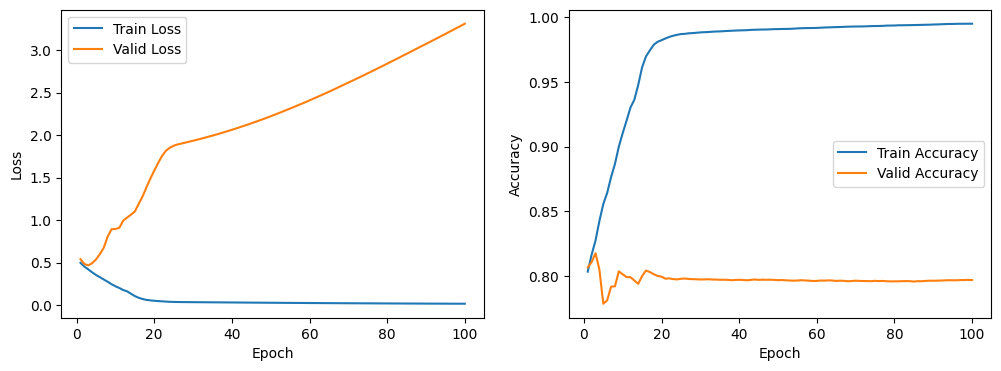

In [23]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Trial5 : Augmentation + ensemble(앙상블중에서 가장 결과가 잘 나온 Trial)

Trial1 - acc : 94.39, ece : 3.69
<br>
Trial2 - acc : 94.63, ece : 3.40
<br>
Trial3 - acc : 94.29, ece : 1.20
<br>
-> Trial3으로 선정

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 생성기 정의
datagen = ImageDataGenerator(
    # rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

# 증강된 데이터를 이용한 학습 데이터셋 생성
def augment_dataset(images, labels, datagen, batch_size):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        img = img.reshape((1,) + img.shape)
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = aug_iter.next().astype(np.float32)
        augmented_images.append(aug_img.reshape(img.shape[1:]))
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

augmented_train_images, augmented_train_labels = augment_dataset(train_images, train_labels, datagen, batch_size)

# numpy array를 tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
augmented_train_dataset = tf.data.Dataset.from_tensor_slices((augmented_train_images, augmented_train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [25]:
def one_hot_encode_dataset(dataset, num_classes):
    def one_hot_encode(image, label):
        return image, tf.one_hot(label, num_classes)
    return dataset.map(one_hot_encode)

# num_classes는 클래스 수에 맞게 수정합니다.
num_classes = 2  # 예시로 2개 클래스인 경우
augmented_train_dataset = one_hot_encode_dataset(augmented_train_dataset, num_classes)
val_dataset = one_hot_encode_dataset(val_dataset, num_classes)
test_dataset = one_hot_encode_dataset(test_dataset, num_classes)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

checkpoint_dir = "/home/iai/Desktop/son/deeplearningproject/best_model"

# 모델 정의
def create_baseline1_model(kernel_size=(3, 3)):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, model_name):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    checkpoint_path_ensemble = os.path.join(checkpoint_dir, f"best_model_trial5_{model_name}.h5")
    checkpoint_ensemble = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_ensemble, monitor='val_loss', save_best_only=True, mode='min')

    history = model.fit(
        augmented_train_dataset,
        validation_data=val_dataset,
        epochs=100,
        batch_size=20,
        callbacks=[checkpoint_ensemble, reduce_lr],
        verbose=0
    )

    model.load_weights(checkpoint_path_ensemble)

    loss, accuracy = model.evaluate(test_dataset)
    print(f"Valid loss: {loss}")
    print(f"Valid accuracy: {accuracy}")

    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    return history, report, y_pred, y_true_classes

# 커널 크기가 다른 여러 모델 생성
kernel_sizes = [(3, 3), (3, 7), (7, 3), (7, 7)]
histories_all = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for experiment in range(10):
    print(f"Experiment {experiment + 1}/10")
    model_list = []
    histories = []
    reports = []
    y_preds = []

    for kernel_size in kernel_sizes:
        model = create_baseline1_model(kernel_size=kernel_size)
        history, report, y_pred, y_true_classes = train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, f"kernel_{kernel_size[0]}x{kernel_size[1]}")
        model_list.append(model)
        histories.append(history)
        reports.append(report)
        y_preds.append(y_pred)

    # 앙상블 예측
    y_pred_ensemble = np.mean(y_preds, axis=0)
    y_pred_classes_ensemble = np.argmax(y_pred_ensemble, axis=1)

    # 앙상블 분류 보고서 생성
    report_ensemble = classification_report(y_true_classes, y_pred_classes_ensemble, target_names=class_names, output_dict=True)
    accuracy_ensemble = report_ensemble['accuracy']
    recall_ensemble = report_ensemble['weighted avg']['recall']
    precision_ensemble = report_ensemble['weighted avg']['precision']
    f1_score_ensemble = report_ensemble['weighted avg']['f1-score']
    
    print(f"Ensemble Accuracy: {accuracy_ensemble}")
    print(f"Ensemble Recall: {recall_ensemble}")
    print(f"Ensemble Precision: {precision_ensemble}")
    print(f"Ensemble F1-score: {f1_score_ensemble}")

    # ECE와 OE 계산
    ece_ensemble = calculate_ece(y_true_classes, y_pred_ensemble)
    oe_ensemble = calculate_oe(y_true_classes, y_pred_ensemble)

    print(f"Ensemble ECE: {ece_ensemble}")
    print(f"Ensemble OE: {oe_ensemble}")

    histories_all.append(histories)
    accuracies.append(accuracy_ensemble)
    recalls.append(recall_ensemble)
    precisions.append(precision_ensemble)
    f1_scores.append(f1_score_ensemble)
    ece_values.append(ece_ensemble)
    oe_values.append(oe_ensemble)


trial_dir = "/home/iai/Desktop/son/deeplearningproject/trial_model"
# 최종 학습된 모델 저장
final_model_path = os.path.join(trial_dir, "trial_5.h5")
model.save(final_model_path)
print(f"Final ensemble model saved at {final_model_path}")

Experiment 1/10
51/51 [==============================] - 0s 894us/step - loss: 0.4845 - accuracy: 0.8070
Valid loss: 0.4845203757286072
Valid accuracy: 0.8070067763328552


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

51/51 [==============================] - 0s 905us/step - loss: 0.4212 - accuracy: 0.8224
Valid loss: 0.4212387204170227
Valid accuracy: 0.8223724365234375
51/51 [==============================] - 0s 881us/step - loss: 0.4328 - accuracy: 0.8236
Valid loss: 0.432801216840744
Valid accuracy: 0.8236017227172852
51/51 [==============================] - 0s 959us/step - loss: 0.4552 - accuracy: 0.8353
Valid loss: 0.4551630914211273
Valid accuracy: 0.835279643535614
Ensemble Accuracy: 0.8309772587584512
Ensemble Recall: 0.8309772587584512
Ensemble Precision: 0.8451580610724856
Ensemble F1-score: 0.7762713203246244
Ensemble ECE: 0.018760837692385013
Ensemble OE: 0.009283017657912424
Experiment 2/10
51/51 [==============================] - 0s 972us/step - loss: 0.4672 - accuracy: 0.8076
Valid loss: 0.46719029545783997
Valid accuracy: 0.8076213598251343
51/51 [==============================] - 0s 889us/step - loss: 0.4706 - accuracy: 0.8021
Valid loss: 0.470554918050766
Valid accuracy: 0.80208975

/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

51/51 [==============================] - 0s 949us/step - loss: 0.4667 - accuracy: 0.8064
Valid loss: 0.46672946214675903
Valid accuracy: 0.8063921332359314
Ensemble Accuracy: 0.8180700676090965
Ensemble Recall: 0.8180700676090965
Ensemble Precision: 0.8515388432384983
Ensemble F1-score: 0.7461835671059739
Ensemble ECE: 0.0333984098920957
Ensemble OE: 0.003502173480917211
Experiment 3/10
51/51 [==============================] - 0s 973us/step - loss: 0.4696 - accuracy: 0.8070
Valid loss: 0.4696285128593445
Valid accuracy: 0.8070067763328552


/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

51/51 [==============================] - 0s 876us/step - loss: 0.4548 - accuracy: 0.8162
Valid loss: 0.4548402726650238
Valid accuracy: 0.8162261843681335
51/51 [==============================] - 0s 975us/step - loss: 0.5012 - accuracy: 0.8181
Valid loss: 0.5012296438217163
Valid accuracy: 0.8180700540542603
51/51 [==============================] - 0s 1ms/step - loss: 0.4040 - accuracy: 0.8457
Valid loss: 0.4040222465991974
Valid accuracy: 0.84572833776474
Ensemble Accuracy: 0.8297480024585125
Ensemble Recall: 0.8297480024585125
Ensemble Precision: 0.8547908344941719
Ensemble F1-score: 0.7715012248613959
Ensemble ECE: 0.043264621851557106
Ensemble OE: 0.006539821844564015
Experiment 4/10
51/51 [==============================] - 0s 891us/step - loss: 0.4745 - accuracy: 0.8125
Valid loss: 0.47447654604911804
Valid accuracy: 0.8125383853912354
51/51 [==============================] - 0s 935us/step - loss: 0.4638 - accuracy: 0.8181
Valid loss: 0.46380358934402466
Valid accuracy: 0.81807005

/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

51/51 [==============================] - 0s 963us/step - loss: 0.4526 - accuracy: 0.8095
Valid loss: 0.45260974764823914
Valid accuracy: 0.8094652891159058
51/51 [==============================] - 0s 1ms/step - loss: 0.4441 - accuracy: 0.8150
Valid loss: 0.44412583112716675
Valid accuracy: 0.8149968981742859
51/51 [==============================] - 0s 890us/step - loss: 0.4414 - accuracy: 0.8107
Valid loss: 0.4413849413394928
Valid accuracy: 0.8106945157051086
Ensemble Accuracy: 0.8119237861094039
Ensemble Recall: 0.8119237861094039
Ensemble Precision: 0.84747123604796
Ensemble F1-score: 0.7323727255345818
Ensemble ECE: 0.039459415755538615
Ensemble OE: 0.01607292791635036
Experiment 8/10
51/51 [==============================] - 0s 948us/step - loss: 0.4807 - accuracy: 0.8045
Valid loss: 0.4806740880012512
Valid accuracy: 0.8045482635498047
51/51 [==============================] - 0s 892us/step - loss: 0.4607 - accuracy: 0.8064
Valid loss: 0.4606824517250061
Valid accuracy: 0.806392133

/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iai/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

51/51 [==============================] - 0s 916us/step - loss: 0.4738 - accuracy: 0.8304
Valid loss: 0.47375527024269104
Valid accuracy: 0.8303626179695129
51/51 [==============================] - 0s 915us/step - loss: 0.4424 - accuracy: 0.8199
Valid loss: 0.4424150884151459
Valid accuracy: 0.819913923740387
51/51 [==============================] - 0s 974us/step - loss: 0.4108 - accuracy: 0.8390
Valid loss: 0.4108331501483917
Valid accuracy: 0.8389674425125122
Ensemble Accuracy: 0.8346650276582668
Ensemble Recall: 0.8346650276582668
Ensemble Precision: 0.8382724031062413
Ensemble F1-score: 0.7868386763692833
Ensemble ECE: 0.02019197301917375
Ensemble OE: 0.00671891914823705
Final ensemble model saved at /home/iai/Desktop/son/deeplearningproject/trial_model/trial_5.h5


In [28]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.8252 ± 0.01
Recall: 0.8252 ± 0.01
Precision: 0.8412 ± 0.01
F1-score: 0.7640 ± 0.02
ECE: 0.0332 ± 0.01
OE: 0.0076 ± 0.00


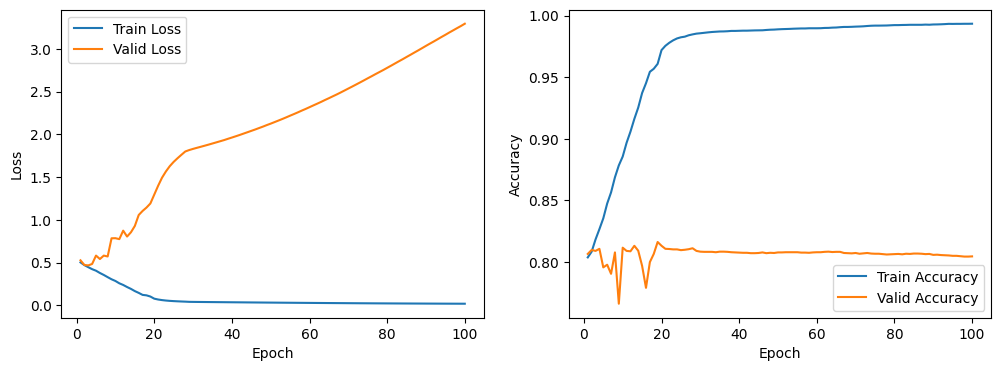

In [29]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델의 경량화와 함께 정확도 유지를 위한 Knowledge Distillation 방법 이용

## Teacher model: 이전 trial1 ~ trial5 중 성능이 가장 좋았던 모델, Student model: Baseline1

Trial1 - acc : 94.39, ece : 3.69
<br>
Trial2 - acc : 94.63, ece : 3.40
<br>
Trial3 - acc : 94.29, ece : 1.20
<br>
Trial4 - acc : 81.49, ece : 4.29
<br>
Trial5 - acc : 82.52, ece : 3.32
<br>
-> Trial3으로 선정

T 값을 조절하면서 정확도와 calibration 성능이 가장 잘 나오는 T값을 찾는다. (1,2,5,10)

### T=1

In [114]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np

# Teacher 모델 로드
teacher_model_path = "/home/iai/Desktop/son/deeplearningproject/trial_model/trial_3.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Student 모델 정의
def create_model(kernel_size=(3, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Knowledge Distillation Loss 정의
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=1.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    student_model = create_model()
    distillation_model = DistillationModel(student=student_model, teacher=teacher_model, temperature=1.0, alpha=0.5)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = distillation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[reduce_lr]
    )

    # 테스트 데이터로 평가
    loss, accuracy = distillation_model.evaluate(test_dataset)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {accuracy}")

    # Classification report
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = student_model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1_score = report['weighted avg']['f1-score']

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1_score)
    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - categorical_accuracy: 0.8320 - student_loss: 0.4275 - distillation_loss: 0.0473 - val_categorical_accuracy: 0.8273 - val_student_loss: 0.4696
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8771 - student_loss: 0.3064 - distillation_loss: 0.0310 - val_categorical_accuracy: 0.8488 - val_student_loss: 0.3105
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9103 - student_loss: 0.2275 - distillation_loss: 0.0210 - val_categorical_accuracy: 0.8691 - val_student_loss: 0.3826
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9361 - student_loss: 0.1722 - distillation_loss: 0.0147 - val_categorical_accuracy: 0.8857 - val_student_loss: 0.2052
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9387 - student_loss: 0.1571 - distillation_loss

In [115]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9120 ± 0.01
Recall: 0.9120 ± 0.01
Precision: 0.9091 ± 0.01
F1-score: 0.9089 ± 0.01
ECE: 0.0626 ± 0.01
OE: 0.0620 ± 0.01


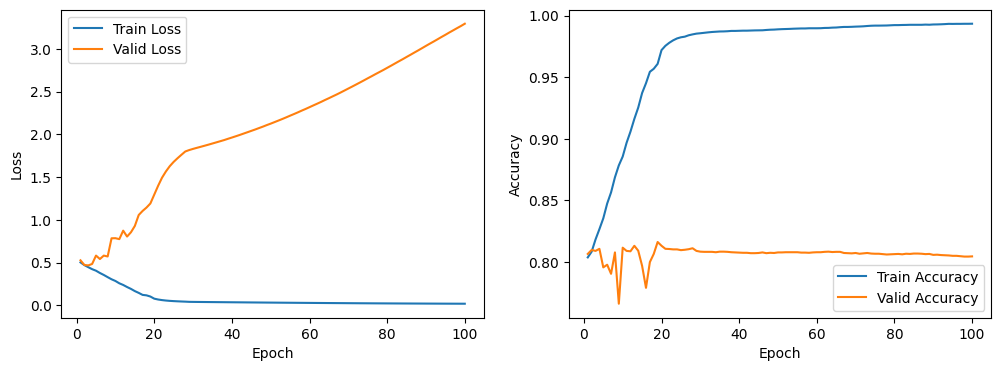

In [116]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### T=2

In [117]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 랜덤 시드 고정
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Teacher 모델 로드
teacher_model_path = "/home/iai/Desktop/son/deeplearningproject/trial_model/trial_3.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Student 모델 정의
def create_model(kernel_size=(3, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Knowledge Distillation Loss 정의
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=2.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    student_model = create_model()
    distillation_model = DistillationModel(student=student_model, teacher=teacher_model, temperature=2.0, alpha=0.5)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = distillation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[reduce_lr]
    )

    # 테스트 데이터로 평가
    loss, accuracy = distillation_model.evaluate(test_dataset)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {accuracy}")

    # Classification report
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = student_model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1_score = report['weighted avg']['f1-score']

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1_score)
    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - categorical_accuracy: 0.8132 - student_loss: 0.4563 - distillation_loss: 0.0140 - val_categorical_accuracy: 0.8310 - val_student_loss: 0.5502
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8486 - student_loss: 0.3571 - distillation_loss: 0.0101 - val_categorical_accuracy: 0.8549 - val_student_loss: 0.3431
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8881 - student_loss: 0.2831 - distillation_loss: 0.0075 - val_categorical_accuracy: 0.8912 - val_student_loss: 0.2855
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9146 - student_loss: 0.2215 - distillation_loss: 0.0055 - val_categorical_accuracy: 0.8273 - val_student_loss: 0.4652
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9303 - student_loss: 0.1816 - distillation_loss

In [118]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9124 ± 0.01
Recall: 0.9124 ± 0.01
Precision: 0.9112 ± 0.01
F1-score: 0.9100 ± 0.01
ECE: 0.0638 ± 0.01
OE: 0.0629 ± 0.01


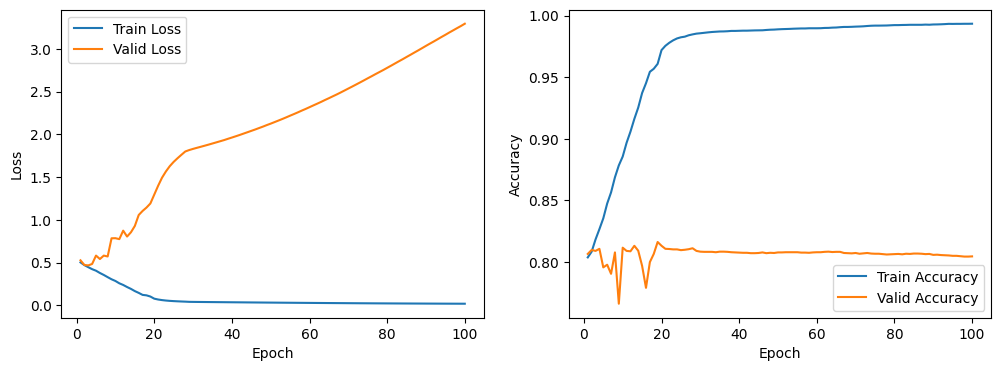

In [119]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### T=5

In [120]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 랜덤 시드 고정
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Teacher 모델 로드
teacher_model_path = "/home/iai/Desktop/son/deeplearningproject/trial_model/trial_3.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Student 모델 정의
def create_model(kernel_size=(3, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Knowledge Distillation Loss 정의
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=5.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    student_model = create_model()
    distillation_model = DistillationModel(student=student_model, teacher=teacher_model, temperature=5.0, alpha=0.5)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = distillation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[reduce_lr]
    )

    # 테스트 데이터로 평가
    loss, accuracy = distillation_model.evaluate(test_dataset)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {accuracy}")

    # Classification report
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = student_model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1_score = report['weighted avg']['f1-score']

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1_score)
    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - categorical_accuracy: 0.8095 - student_loss: 0.4557 - distillation_loss: 0.0023 - val_categorical_accuracy: 0.8267 - val_student_loss: 0.5751
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8586 - student_loss: 0.3425 - distillation_loss: 0.0016 - val_categorical_accuracy: 0.8531 - val_student_loss: 0.3990
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8996 - student_loss: 0.2566 - distillation_loss: 0.0011 - val_categorical_accuracy: 0.8556 - val_student_loss: 0.4314
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9230 - student_loss: 0.1994 - distillation_loss: 7.8916e-04 - val_categorical_accuracy: 0.8924 - val_student_loss: 0.2228
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9318 - student_loss: 0.1717 - distillation_

In [121]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9120 ± 0.01
Recall: 0.9120 ± 0.01
Precision: 0.9098 ± 0.01
F1-score: 0.9097 ± 0.01
ECE: 0.0630 ± 0.01
OE: 0.0625 ± 0.01


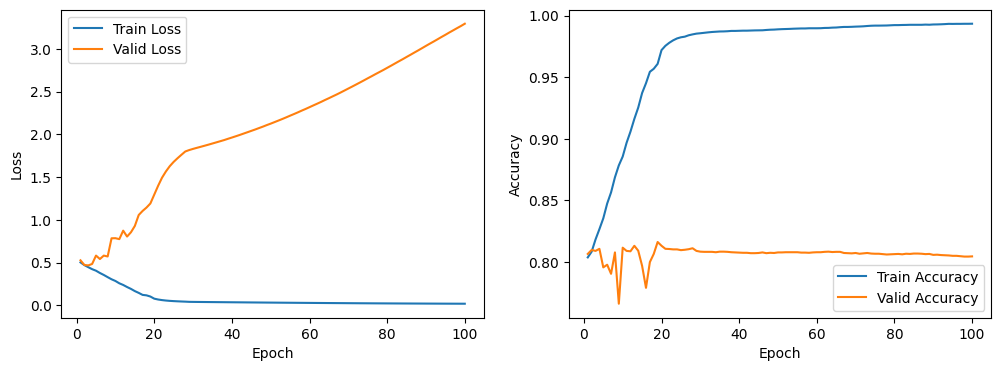

In [122]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### T=10

In [123]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 랜덤 시드 고정
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Teacher 모델 로드
teacher_model_path = "/home/iai/Desktop/son/deeplearningproject/trial_model/trial_3.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Student 모델 정의
def create_model(kernel_size=(3, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Knowledge Distillation Loss 정의
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=10.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    student_model = create_model()
    distillation_model = DistillationModel(student=student_model, teacher=teacher_model, temperature=10.0, alpha=0.5)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = distillation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[reduce_lr]
    )

    # 테스트 데이터로 평가
    loss, accuracy = distillation_model.evaluate(test_dataset)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {accuracy}")

    # Classification report
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = student_model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1_score = report['weighted avg']['f1-score']

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1_score)
    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - categorical_accuracy: 0.8111 - student_loss: 0.4591 - distillation_loss: 5.8081e-04 - val_categorical_accuracy: 0.8230 - val_student_loss: 0.5036
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8517 - student_loss: 0.3592 - distillation_loss: 4.2347e-04 - val_categorical_accuracy: 0.8033 - val_student_loss: 0.5343
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8867 - student_loss: 0.2883 - distillation_loss: 3.1093e-04 - val_categorical_accuracy: 0.8808 - val_student_loss: 0.2933
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9146 - student_loss: 0.2237 - distillation_loss: 2.2456e-04 - val_categorical_accuracy: 0.8304 - val_student_loss: 0.3870
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9283 - student_loss: 0.1865 - d

In [124]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9213 ± 0.01
Recall: 0.9213 ± 0.01
Precision: 0.9191 ± 0.01
F1-score: 0.9189 ± 0.01
ECE: 0.0544 ± 0.01
OE: 0.0535 ± 0.01


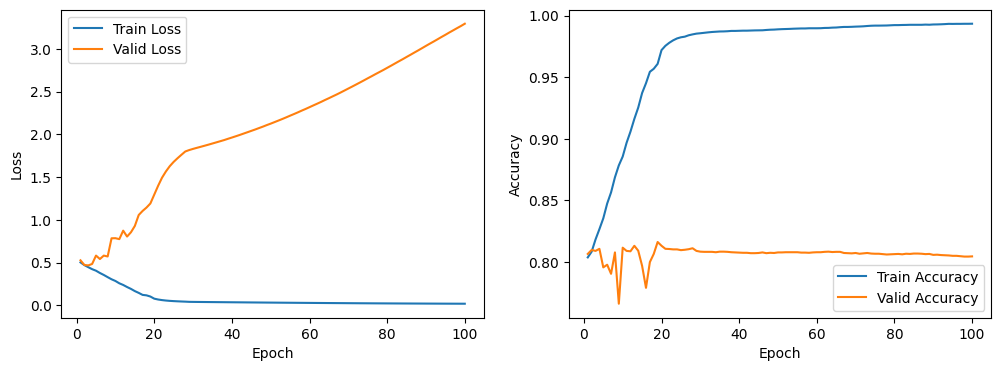

In [125]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### t=20

In [126]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 랜덤 시드 고정
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# Teacher 모델 로드
teacher_model_path = "/home/iai/Desktop/son/deeplearningproject/trial_model/trial_3.h5"
teacher_model = tf.keras.models.load_model(teacher_model_path)

# Student 모델 정의
def create_model(kernel_size=(3, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=(28, 28, 3)),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.AveragePooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # 클래스 수에 맞게 수정 필요
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Knowledge Distillation Loss 정의
class DistillationModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature=20.0, alpha=0.5):
        super(DistillationModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn):
        super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

accuracies = []
recalls = []
precisions = []
f1_scores = []
ece_values = []
oe_values = []

for i in range(10):
    print(f"Experiment {i+1}/10")
    
    student_model = create_model()
    distillation_model = DistillationModel(student=student_model, teacher=teacher_model, temperature=20.0, alpha=0.5)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
        student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
        distillation_loss_fn=tf.keras.losses.KLDivergence(),
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

    history = distillation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=[reduce_lr]
    )

    # 테스트 데이터로 평가
    loss, accuracy = distillation_model.evaluate(test_dataset)
    print(f"Test loss: {loss}")
    print(f"Test accuracy: {accuracy}")

    # Classification report
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_pred = student_model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    accuracy = report['accuracy']
    recall = report['weighted avg']['recall']
    precision = report['weighted avg']['precision']
    f1_score = report['weighted avg']['f1-score']

    ece = calculate_ece(y_true_classes, y_pred)
    oe = calculate_oe(y_true_classes, y_pred)

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1_score)
    ece_values.append(ece)
    oe_values.append(oe)

Experiment 1/10
Epoch 1/100
153/153 [==============================] - 1s 3ms/step - categorical_accuracy: 0.8095 - student_loss: 0.4576 - distillation_loss: 1.4465e-04 - val_categorical_accuracy: 0.8291 - val_student_loss: 0.5204
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8500 - student_loss: 0.3631 - distillation_loss: 1.0642e-04 - val_categorical_accuracy: 0.8414 - val_student_loss: 0.4334
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.8851 - student_loss: 0.2866 - distillation_loss: 7.8101e-05 - val_categorical_accuracy: 0.8187 - val_student_loss: 0.4837
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9144 - student_loss: 0.2160 - distillation_loss: 5.3755e-05 - val_categorical_accuracy: 0.8740 - val_student_loss: 0.2956
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - categorical_accuracy: 0.9308 - student_loss: 0.1803 - d

In [127]:
# 평균 및 표준편차 계산
accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

recall_mean = np.mean(recalls)
recall_std = np.std(recalls)

precision_mean = np.mean(precisions)
precision_std = np.std(precisions)

f1_score_mean = np.mean(f1_scores)
f1_score_std = np.std(f1_scores)

ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)

oe_mean = np.mean(oe_values)
oe_std = np.std(oe_values)

# 결과 출력
print(f"Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.2f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.2f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.2f}")
print(f"F1-score: {f1_score_mean:.4f} ± {f1_score_std:.2f}")
print(f"ECE: {ece_mean:.4f} ± {ece_std:.2f}")
print(f"OE: {oe_mean:.4f} ± {oe_std:.2f}")

Accuracy: 0.9180 ± 0.01
Recall: 0.9180 ± 0.01
Precision: 0.9154 ± 0.01
F1-score: 0.9155 ± 0.01
ECE: 0.0585 ± 0.01
OE: 0.0572 ± 0.01


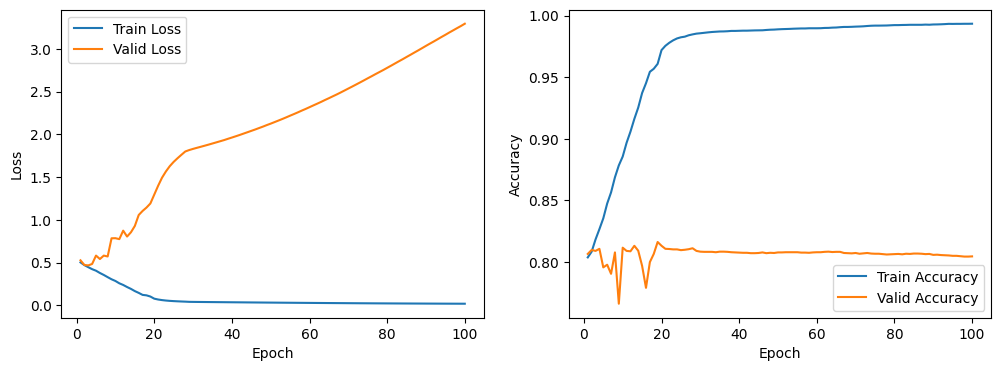

In [128]:
# 에포크별 평균 손실 및 정확도 계산
epochs = range(1, 101)
avg_train_loss = np.mean([history.history['loss'] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'] for history in histories], axis=0)
avg_train_accuracy = np.mean([history.history['accuracy'] for history in histories], axis=0)
avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories], axis=0)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_loss, label='Train Loss')
plt.plot(epochs, avg_val_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accuracy, label='Train Accuracy')
plt.plot(epochs, avg_val_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

KD를 했을 때, T=10일 때 가장 정확도가 높다.

장애를 진단하는 시설에서 리소스가 충분하다면 trial3의 앙상블 모델을 사용하여 정확도, calibration이 잘 된 모델을 사용하면 된다.
<br>
만약 부족하다면, baseline1보다 정확도가 향상된 KD를 사용한 모델을 사용하면 같은 크기의 모델이지만 더욱 정확도가 향상된 모델을 사용할 수 있어 효율적이다.